## SolCx analytic solution with error analysis

The SolCx analytic solution is run over a range of resolutions with the error (in velocity and pressure) measured at each conffiguration. The error convergence is analysed against the expected element type order.

In [2]:
import underworld as uw
import glucifer
from underworld import function as fn
import numpy as np

In [3]:
# SolCx object contains the analytic solution and parameter (ie, viscosity, density) profiles
sol = fn.analytic.SolCx(viscosityA=1.0, viscosityB=1e5, xc=0.25, nx=3)
# sol = fn.analytic.SolKx(B=10.0, nx=2.0, nz=4)

In [4]:
elTypeToUse = "Q1/dQ0"

# expected order of convergence results for Q1/dQ0
# velocity for Q1 -> 2nd order convergence
# pressure is dQ0 -> 1st order convergence 
expected_order = np.array([1.9,1.9,0.9])

# Resolutions to test against
res = [(32,32), (64,64), (128,128), (256,256)]

In [5]:
def analyticMeasure( numeric, analytic, mesh ):
    '''
    Measure the integrated error between 2 MeshVariables (or uw.Functions) over the mesh
    
    Returns
    -------
    rel, err: ndarray, ndarray
        Array representing the relative and absolute errors between the MeshVariables
        The lengths are the number of components of the field
    '''
    
    # functional description of L2 norm sums; error and magnitude
    fn_err = fn.math.pow(numeric - analytic, 2.)
    fn_norm = fn.math.pow(analytic, 2.)
    
    # perform L2 norm evaluation        
    err = fn.math.sqrt(uw.utils.Integral( fn_err, mesh ).evaluate()).evaluate()[0]
    norm = fn.math.sqrt(uw.utils.Integral( fn_norm, mesh ).evaluate()).evaluate()[0]
    
    # calculate relative error measures
    rel = err / norm
    
    return rel, err

In [6]:
def analyticSol_SingleResolutionTest( sol, elType, resolution ):
    """
    Test a FEM model against an analytic solution
    
    Parameters
    ----------
    sol : fn.analyic._SolBase
        The python wrapped analyic solution.
        
    elType: string
        The element type desired, as these equation solve stokes this must
        describe a mesh/subMesh pair, eg 'Q1/dQ0'.
    
    resolution: integer tuple
        The resolution of the mesh.
    """

    # 'global' python vars are visible outside this function's scope
    global mesh
    global velocityField
    global pressureField
    global solver
    
    mesh = uw.mesh.FeMesh_Cartesian(elType, resolution, (0.,0.), (1.,1.))

    velocityField = mesh.add_variable(2)
    velocityField.data[:] = (0.,0.)
    pressureField = mesh.subMesh.add_variable(1)
    pressureField.data[:] = 0.

    # currently not checking strain rate
    # strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
    
    # freeslip
    IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
    JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
    freeslip = uw.conditions.DirichletCondition(velocityField, (IWalls, JWalls))

    stokesSystem = uw.systems.Stokes(velocityField,pressureField,
                                     sol.fn_viscosity,sol.fn_bodyforce,
                                     conditions=[freeslip,])
    #Run the BSSCR Solver
    # # can optionally set penalty this way
    solver=uw.systems.Solver(stokesSystem)
    solver.options.scr.ksp_rtol=1e-6  # tolerance for the scr solve, default is 1e-5.
    solver.options.A11.ksp_rtol=1e-5  # tolerance for the inv K approximation
    solver.solve()
    
    v_err, abs_v_err = analyticMeasure( velocityField, sol.fn_velocity, mesh )
    p_err, abs_p_err = analyticMeasure( pressureField, sol.fn_pressure, mesh )
    
    return v_err, p_err

In [7]:
# store the error measures
vx = []
vy = []
p  = []

ssize = len(res) # the number of samples

for i in xrange(ssize):
    test_err = analyticSol_SingleResolutionTest( sol, elTypeToUse, res[i])
    
    vx.append(test_err[0][0]) # get vx error
    vy.append(test_err[0][1]) # get vy
    p.append(test_err[1][0])  # get pressure

In [8]:
res_x = np.asarray( res )[:,0] # assume square resolutions

In [9]:
h = np.log(np.reciprocal(res_x.astype(float)))

In [10]:
A = np.vstack([h, np.ones(len(h))]).T

In [11]:
# take the log of all dependent variables
yvx = np.log(vx)
yvy = np.log(vy)
yp  = np.log(p)

In [12]:
vxm, c = np.linalg.lstsq(A, yvx)[0]
vym, c = np.linalg.lstsq(A, yvy)[0]
pm, c = np.linalg.lstsq(A, yp)[0]

In [13]:
test = np.array([vxm, vym, pm])

In [14]:
if uw.rank()==0:
    np.all(np.less(expected_order, test))

    if not np.all(np.less(expected_order, test)):
        raise RuntimeError("The numerical order of convergence is outside the error threshold."+
        "The Relative error found were ", test," the threshold is ", expected_order )  

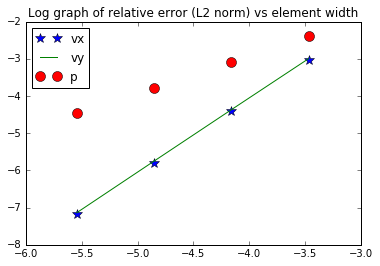

In [24]:
if uw.rank()==0:
    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.plot(h, yvx, '*', label='vx', markersize=10)
    pyplot.plot(h, yvy, '-', label='vy', markersize=10)
    pyplot.plot(h, yp, 'o', label='p', markersize=10)
    pyplot.legend(loc=2)
    pyplot.title("Log graph of relative error (L2 norm) vs element width")
    pyplot.savefig("solCx") if uw.nProcs() > 1 else pyplot.show()

In [16]:
# figViscosity = glucifer.Figure()
# figForce = glucifer.Figure(**figViscosity)

In [17]:
# figViscosity.append( glucifer.objects.Surface(mesh, fn=sol.fn_viscosity, onMesh=True) )
# figViscosity.append( glucifer.objects.Mesh(mesh))
# figViscosity.show()
# figForce.append( glucifer.objects.Surface(mesh, fn=sol.fn_bodyforce[1], onMesh=True) )
# figForce.show()

In [18]:
# figSR = glucifer.Figure(**figViscosity)
# figSR.append( glucifer.objects.Surface(mesh, fn=pressureField ) )
# figSR.show()